## Imports

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import datetime
import CovidAPI

# pip install cassandra-driver
from cassandra.cluster import Cluster

## Data

### Cassandra stuff

In [2]:
# Get info on single country
# country: String with a capital letter
def getCountryInfo(country):
    prep = session.prepare("SELECT * FROM countryinfo WHERE country=?")
    result = session.execute(prep, [country])
    return result

# Get info on all available countries
def getAllCountryInfo():
    result = session.execute("SELECT * from countryinfo")
    return result

cluster = Cluster()
session = cluster.connect("covid")
print(getCountryInfo("Iceland").all())


[Row(country='Iceland', date='2020-10-23', deathrate=117.99199676513672, newconfirmed=38.0, newdeaths=0.0, population=341250.0, totalconfirmed=4268.0, totaldeaths=11.0)]


### Not cassandra stuff

In [19]:
def getDataPoints(X, y, countryData):
    cases = []
    # Only get relevant data
    for d in countryData:
        cases.append((d["Confirmed"], d["Date"].split("T")[0]))
        
    # Create data points for X and corresponding y
    # For each datapoint 0:N-14
    for i in range(len(cases)-14):
        timeRange = []
        # For selected date n:n+13
        for k in range(14):
            timeRange.append(cases[i+k][0])
        X.append(timeRange)
        # Target is 15th day
        y.append(cases[i+14][0])
    return X, y


        
    
X = []
y = []

api = CovidAPI.API()
data = api.getDayOneCountry("Madagascar")
#data = api.getAllCountryCases()
#print(data[1])

#for d in data:
#    X, y = getDataPoints(X, y, d)
X, y = getDataPoints(X, y, data)
    
X = np.asarray(X)#.reshape((len(X), len(X[0]), 1))
y = np.asarray(y)#.reshape((len(y), 1))

dim = X.shape[1]
N = X.shape[0]

print("X dimensions:", dim)
print("No. data points:", N)

X dimensions: 14
No. data points: 205


In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=False)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

X_train shape: (137, 14)
y_train shape: (137,)


## LSTM

In [126]:
tf.keras.backend.clear_session()
model = Sequential()
model.add(LSTM(50, input_shape=(14, 1), return_sequences=True, stateful=False))
model.add(LSTM(50, input_shape=(1, 50), return_sequences=True, stateful=False))
model.add(LSTM(50, input_shape=(1, 50), return_sequences=False, stateful=False))
model.add(Dropout(0.3))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
NUM_EPOCHS = 1000

result = model.fit(X_train, y_train, batch_size = 1, validation_data = (X_test, y_test), verbose = 1, epochs = NUM_EPOCHS, callbacks=[callback])

Epoch 1/1000
137/137 [==============================] - 2s 13ms/step - loss: 31438750.0000 - val_loss: 251276240.0000
Epoch 2/1000
137/137 [==============================] - 1s 8ms/step - loss: 31394610.0000 - val_loss: 251138304.0000
Epoch 3/1000
137/137 [==============================] - 1s 8ms/step - loss: 31368858.0000 - val_loss: 251022816.0000
Epoch 4/1000
137/137 [==============================] - 1s 8ms/step - loss: 31345222.0000 - val_loss: 250915248.0000
Epoch 5/1000
137/137 [==============================] - 1s 8ms/step - loss: 31318748.0000 - val_loss: 250796928.0000
Epoch 6/1000
137/137 [==============================] - 1s 8ms/step - loss: 31297376.0000 - val_loss: 250683968.0000
Epoch 7/1000
137/137 [==============================] - 1s 8ms/step - loss: 31272984.0000 - val_loss: 250578048.0000
Epoch 8/1000
137/137 [==============================] - 1s 8ms/step - loss: 31251240.0000 - val_loss: 250469776.0000
Epoch 9/1000
137/137 [==============================] - 1s 8ms/

137/137 [==============================] - 1s 9ms/step - loss: 28393778.0000 - val_loss: 236550368.0000
Epoch 140/1000
137/137 [==============================] - 1s 9ms/step - loss: 28352282.0000 - val_loss: 236448240.0000
Epoch 141/1000
137/137 [==============================] - 1s 8ms/step - loss: 28327950.0000 - val_loss: 236350400.0000
Epoch 142/1000
137/137 [==============================] - 1s 9ms/step - loss: 28340936.0000 - val_loss: 236244704.0000
Epoch 143/1000
137/137 [==============================] - 1s 8ms/step - loss: 28326356.0000 - val_loss: 236138112.0000
Epoch 144/1000
137/137 [==============================] - 1s 9ms/step - loss: 28325502.0000 - val_loss: 236038672.0000
Epoch 145/1000
137/137 [==============================] - 1s 8ms/step - loss: 28247554.0000 - val_loss: 235936528.0000
Epoch 146/1000
137/137 [==============================] - 1s 8ms/step - loss: 28239560.0000 - val_loss: 235832832.0000
Epoch 147/1000
137/137 [==============================] - 1s 8m

Epoch 208/1000
137/137 [==============================] - 1s 8ms/step - loss: 26945810.0000 - val_loss: 229611216.0000
Epoch 209/1000
137/137 [==============================] - 1s 9ms/step - loss: 26943936.0000 - val_loss: 229507600.0000
Epoch 210/1000
137/137 [==============================] - 1s 9ms/step - loss: 27047400.0000 - val_loss: 229410448.0000
Epoch 211/1000
137/137 [==============================] - 1s 8ms/step - loss: 27082250.0000 - val_loss: 229315408.0000
Epoch 212/1000
137/137 [==============================] - 1s 8ms/step - loss: 27002760.0000 - val_loss: 229213056.0000
Epoch 213/1000
137/137 [==============================] - 1s 8ms/step - loss: 26889418.0000 - val_loss: 229120944.0000
Epoch 214/1000
137/137 [==============================] - 1s 9ms/step - loss: 26833470.0000 - val_loss: 229016880.0000
Epoch 215/1000
137/137 [==============================] - 1s 8ms/step - loss: 26870048.0000 - val_loss: 228920304.0000
Epoch 216/1000
137/137 [========================

Epoch 277/1000
137/137 [==============================] - 1s 8ms/step - loss: 25796510.0000 - val_loss: 222905440.0000
Epoch 278/1000
137/137 [==============================] - 1s 8ms/step - loss: 25812362.0000 - val_loss: 222816720.0000
Epoch 279/1000
137/137 [==============================] - 1s 8ms/step - loss: 25707314.0000 - val_loss: 222716672.0000
Epoch 280/1000
137/137 [==============================] - 1s 8ms/step - loss: 25738170.0000 - val_loss: 222621840.0000
Epoch 281/1000
137/137 [==============================] - 1s 8ms/step - loss: 25815936.0000 - val_loss: 222533152.0000
Epoch 282/1000
137/137 [==============================] - 1s 8ms/step - loss: 25715992.0000 - val_loss: 222434496.0000
Epoch 283/1000
137/137 [==============================] - 1s 8ms/step - loss: 25763920.0000 - val_loss: 222343712.0000
Epoch 284/1000
137/137 [==============================] - 1s 8ms/step - loss: 25801628.0000 - val_loss: 222251296.0000
Epoch 285/1000
137/137 [========================

Epoch 346/1000
137/137 [==============================] - 1s 8ms/step - loss: 24649122.0000 - val_loss: 216453808.0000
Epoch 347/1000
137/137 [==============================] - 1s 8ms/step - loss: 24526536.0000 - val_loss: 216363376.0000
Epoch 348/1000
137/137 [==============================] - 1s 8ms/step - loss: 24547148.0000 - val_loss: 216272160.0000
Epoch 349/1000
137/137 [==============================] - 1s 8ms/step - loss: 24381794.0000 - val_loss: 216178368.0000
Epoch 350/1000
137/137 [==============================] - 1s 8ms/step - loss: 24546314.0000 - val_loss: 216085840.0000
Epoch 351/1000
137/137 [==============================] - 1s 8ms/step - loss: 24573422.0000 - val_loss: 215996544.0000
Epoch 352/1000
137/137 [==============================] - 1s 8ms/step - loss: 24474910.0000 - val_loss: 215898800.0000
Epoch 353/1000
137/137 [==============================] - 1s 8ms/step - loss: 24507776.0000 - val_loss: 215810224.0000
Epoch 354/1000
137/137 [========================

Epoch 415/1000
137/137 [==============================] - 1s 8ms/step - loss: 23561030.0000 - val_loss: 210197920.0000
Epoch 416/1000
137/137 [==============================] - 1s 8ms/step - loss: 23487894.0000 - val_loss: 210110176.0000
Epoch 417/1000
137/137 [==============================] - 1s 8ms/step - loss: 23412896.0000 - val_loss: 210021424.0000
Epoch 418/1000
137/137 [==============================] - 1s 8ms/step - loss: 23232722.0000 - val_loss: 209932624.0000
Epoch 419/1000
137/137 [==============================] - 1s 8ms/step - loss: 23381510.0000 - val_loss: 209841600.0000
Epoch 420/1000
137/137 [==============================] - 1s 8ms/step - loss: 23503884.0000 - val_loss: 211331264.0000
Epoch 421/1000
137/137 [==============================] - 1s 8ms/step - loss: 23497216.0000 - val_loss: 209665056.0000
Epoch 422/1000
137/137 [==============================] - 1s 8ms/step - loss: 23339566.0000 - val_loss: 209579424.0000
Epoch 423/1000
137/137 [========================

Epoch 484/1000
137/137 [==============================] - 1s 8ms/step - loss: 22367582.0000 - val_loss: 204156368.0000
Epoch 485/1000
137/137 [==============================] - 1s 8ms/step - loss: 22487874.0000 - val_loss: 204067440.0000
Epoch 486/1000
137/137 [==============================] - 1s 8ms/step - loss: 22398306.0000 - val_loss: 203982144.0000
Epoch 487/1000
137/137 [==============================] - 1s 8ms/step - loss: 22535116.0000 - val_loss: 203894608.0000
Epoch 488/1000
137/137 [==============================] - 1s 8ms/step - loss: 22379962.0000 - val_loss: 203811696.0000
Epoch 489/1000
137/137 [==============================] - 1s 9ms/step - loss: 22247806.0000 - val_loss: 203723520.0000
Epoch 490/1000
137/137 [==============================] - 1s 9ms/step - loss: 22260300.0000 - val_loss: 203635392.0000
Epoch 491/1000
137/137 [==============================] - 1s 8ms/step - loss: 22344994.0000 - val_loss: 203550704.0000
Epoch 492/1000
137/137 [========================

Epoch 553/1000
137/137 [==============================] - 1s 9ms/step - loss: 21503636.0000 - val_loss: 198274288.0000
Epoch 554/1000
137/137 [==============================] - 1s 9ms/step - loss: 21542150.0000 - val_loss: 198185696.0000
Epoch 555/1000
137/137 [==============================] - 1s 9ms/step - loss: 21698310.0000 - val_loss: 198105040.0000
Epoch 556/1000
137/137 [==============================] - 1s 9ms/step - loss: 21318946.0000 - val_loss: 198017344.0000
Epoch 557/1000
137/137 [==============================] - 1s 9ms/step - loss: 21268864.0000 - val_loss: 197934512.0000
Epoch 558/1000
137/137 [==============================] - 1s 9ms/step - loss: 21621258.0000 - val_loss: 197852800.0000
Epoch 559/1000
137/137 [==============================] - 1s 9ms/step - loss: 21540062.0000 - val_loss: 197774800.0000
Epoch 560/1000
137/137 [==============================] - 1s 9ms/step - loss: 21059324.0000 - val_loss: 197681680.0000
Epoch 561/1000
137/137 [========================

Epoch 622/1000
137/137 [==============================] - 1s 8ms/step - loss: 20516978.0000 - val_loss: 192619984.0000
Epoch 623/1000
137/137 [==============================] - 1s 9ms/step - loss: 20719102.0000 - val_loss: 192545408.0000
Epoch 624/1000
137/137 [==============================] - 1s 9ms/step - loss: 20564818.0000 - val_loss: 192463888.0000
Epoch 625/1000
137/137 [==============================] - 1s 9ms/step - loss: 20397086.0000 - val_loss: 192385152.0000
Epoch 626/1000
137/137 [==============================] - 1s 9ms/step - loss: 20641726.0000 - val_loss: 192305776.0000
Epoch 627/1000
137/137 [==============================] - 1s 8ms/step - loss: 20689436.0000 - val_loss: 194833712.0000
Epoch 628/1000
137/137 [==============================] - 1s 8ms/step - loss: 21161506.0000 - val_loss: 194381312.0000
Epoch 629/1000
137/137 [==============================] - 1s 9ms/step - loss: 20870776.0000 - val_loss: 193510240.0000
Epoch 630/1000
137/137 [========================

Epoch 691/1000
137/137 [==============================] - 1s 8ms/step - loss: 19490628.0000 - val_loss: 187067968.0000
Epoch 692/1000
137/137 [==============================] - 1s 9ms/step - loss: 19627746.0000 - val_loss: 186990400.0000
Epoch 693/1000
137/137 [==============================] - 1s 8ms/step - loss: 19481722.0000 - val_loss: 186909760.0000
Epoch 694/1000
137/137 [==============================] - 1s 9ms/step - loss: 19651476.0000 - val_loss: 186830096.0000
Epoch 695/1000
137/137 [==============================] - 1s 9ms/step - loss: 19653162.0000 - val_loss: 186753008.0000
Epoch 696/1000
137/137 [==============================] - 1s 9ms/step - loss: 19602304.0000 - val_loss: 186669408.0000
Epoch 697/1000
137/137 [==============================] - 1s 9ms/step - loss: 19636696.0000 - val_loss: 186591360.0000
Epoch 698/1000
137/137 [==============================] - 1s 9ms/step - loss: 19530720.0000 - val_loss: 186512160.0000
Epoch 699/1000
137/137 [========================

In [62]:
from tensorflow.keras.layers import Dense, Dropout, Input, LSTM
from tensorflow.keras.models import Model, Sequential

tf.keras.backend.clear_session()

#model = Sequential()
#model.add()
#model.add(LSTM(14, input_shape=(dim), return_sequences=True, stateful=False))
#model.add(LSTM(20, input_shape=(dim), return_sequences=False, stateful=False))
#model.add(Dense(1, activation='linear'))
#model.compile(loss='mse', optimizer='adam')

# model = Sequential()
# model.add(LSTM(14, activation='relu', return_sequences=True, input_shape=(dim,1)))
# model.add(LSTM(14, activation='relu'))
# model.add(Dropout(0.3))
# model.add(Dense(1, activation='linear'))

#define the learning rate
# optimizer = keras.optimizers.Adam(lr=learning_rate)

#compile model
# model.compile(optimizer=optimizer, loss='mae')

input_layer = Input(shape=(dim))
dense1 = Dense(60, activation='relu')(input_layer)
dense2 = Dense(100, activation='relu')(dense1)
dense3 = Dense(100, activation='relu')(dense2)
dense4 = Dense(100, activation='relu')(dense3)
dropout_layer = Dropout(0.2)(dense4)
output_layer = Dense(1, activation='linear')(dropout_layer)
optimizer = tf.keras.optimizers.Adam(lr=0.000001)
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=50,
    decay_rate=0.9)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(loss=tf.keras.losses.MeanAbsolutePercentageError(), optimizer=optimizer)
model.summary()

model.fit(X_train, y_train, batch_size=5, epochs=208,
          validation_data=(X_test, y_test), shuffle=True, callbacks=[callback])

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 14)]              0         
_________________________________________________________________
dense (Dense)                (None, 60)                900       
_________________________________________________________________
dense_1 (Dense)              (None, 100)               6100      
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                

Epoch 69/208
28/28 [==============================] - 0s 2ms/step - loss: 74.2125 - val_loss: 66.5857
Epoch 70/208
28/28 [==============================] - 0s 2ms/step - loss: 74.7701 - val_loss: 66.1227
Epoch 71/208
28/28 [==============================] - 0s 2ms/step - loss: 74.2592 - val_loss: 65.6581
Epoch 72/208
28/28 [==============================] - 0s 2ms/step - loss: 73.9533 - val_loss: 65.2018
Epoch 73/208
28/28 [==============================] - 0s 2ms/step - loss: 73.4148 - val_loss: 64.7349
Epoch 74/208
28/28 [==============================] - 0s 1ms/step - loss: 72.6692 - val_loss: 64.2637
Epoch 75/208
28/28 [==============================] - 0s 2ms/step - loss: 72.8146 - val_loss: 63.7894
Epoch 76/208
28/28 [==============================] - 0s 2ms/step - loss: 72.6444 - val_loss: 63.3192
Epoch 77/208
28/28 [==============================] - 0s 2ms/step - loss: 71.4960 - val_loss: 62.8509
Epoch 78/208
28/28 [==============================] - 0s 2ms/step - loss: 71.1006 

Epoch 149/208
28/28 [==============================] - 0s 2ms/step - loss: 42.6651 - val_loss: 24.4186
Epoch 150/208
28/28 [==============================] - 0s 2ms/step - loss: 39.9423 - val_loss: 23.8469
Epoch 151/208
28/28 [==============================] - 0s 2ms/step - loss: 42.9277 - val_loss: 23.2796
Epoch 152/208
28/28 [==============================] - 0s 2ms/step - loss: 40.7466 - val_loss: 22.6966
Epoch 153/208
28/28 [==============================] - 0s 1ms/step - loss: 40.0174 - val_loss: 22.1213
Epoch 154/208
28/28 [==============================] - 0s 2ms/step - loss: 40.6061 - val_loss: 21.5581
Epoch 155/208
28/28 [==============================] - 0s 1ms/step - loss: 38.5691 - val_loss: 20.9818
Epoch 156/208
28/28 [==============================] - 0s 2ms/step - loss: 37.1721 - val_loss: 20.3906
Epoch 157/208
28/28 [==============================] - 0s 2ms/step - loss: 38.1831 - val_loss: 19.8038
Epoch 158/208
28/28 [==============================] - 0s 2ms/step - loss

[14402, 14475, 14554, 14592, 14696, 14791, 14843, 14863, 14957, 15023, 15106, 15187, 15269, 15319]
[14475, 14554, 14592, 14696, 14791, 14843, 14863, 14957, 15023, 15106, 15187, 15269, 15319, 15187.6]
[14554, 14592, 14696, 14791, 14843, 14863, 14957, 15023, 15106, 15187, 15269, 15319, 15187.6, 15219.303]
[14592, 14696, 14791, 14843, 14863, 14957, 15023, 15106, 15187, 15269, 15319, 15187.6, 15219.303, 15276.3]
[14696, 14791, 14843, 14863, 14957, 15023, 15106, 15187, 15269, 15319, 15187.6, 15219.303, 15276.3, 15335.321]
[14791, 14843, 14863, 14957, 15023, 15106, 15187, 15269, 15319, 15187.6, 15219.303, 15276.3, 15335.321, 15372.911]
[14843, 14863, 14957, 15023, 15106, 15187, 15269, 15319, 15187.6, 15219.303, 15276.3, 15335.321, 15372.911, 15416.742]
[14863, 14957, 15023, 15106, 15187, 15269, 15319, 15187.6, 15219.303, 15276.3, 15335.321, 15372.911, 15416.742, 15465.79]
[14957, 15023, 15106, 15187, 15269, 15319, 15187.6, 15219.303, 15276.3, 15335.321, 15372.911, 15416.742, 15465.79, 15519.

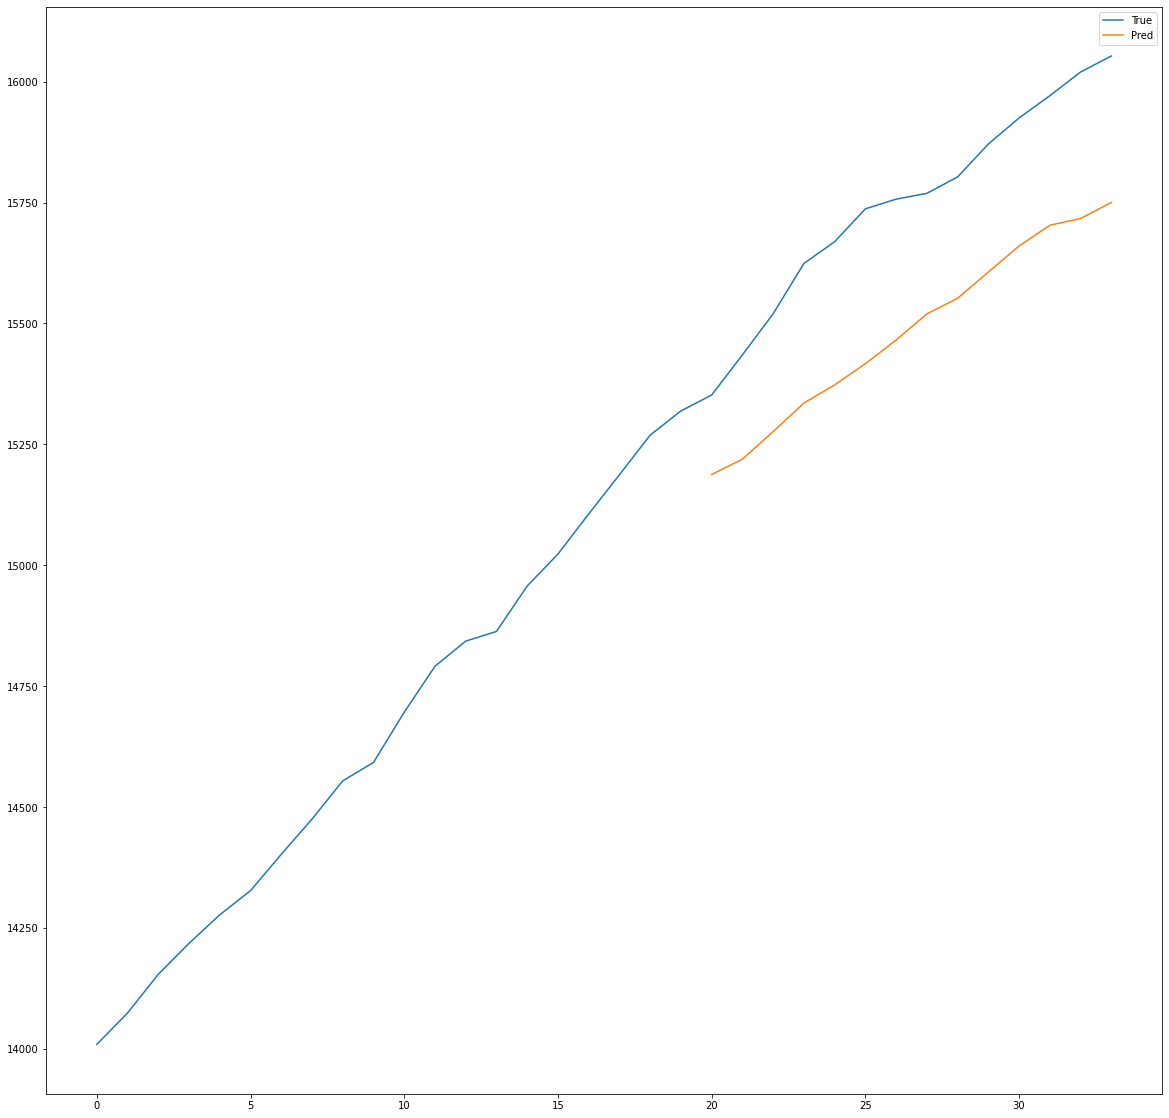

In [63]:
point=20
y_pred = []
initX = X_test[point]
model.predict(np.asarray(initX).reshape((1,14)))

indx = 0
for i in range(14):
    newpred = []
    for j in range(0+indx, 14):
        newpred.append(initX[j])
    for j in y_pred:
        newpred.append(j)
    indx += 1
    y_pred.append(model.predict(np.asarray(newpred).reshape((1,14)))[0][0])
    print(newpred)
    
print(y_test[point])
print(y_test.shape[0])

n = point + 14
plt.figure(figsize=(20,20))
plt.plot(np.arange(0,n), y_test[0:n], label="True")
plt.plot(np.arange(n-14,n), y_pred, label="Pred")
plt.legend()
plt.show()
